# CLIP

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.functional as F
import tqdm

from torchvision import models
from tqdm import tqdm

/home/maui/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fashion Product Image Dataset: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small

In [2]:
import pandas as pd

# Load the data (the csv file has some bad lines)
df = pd.read_csv('data/myntradataset/styles.csv', on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [3]:
# Drop the rows with missing values
nan_values = df[df['productDisplayName'].isnull()].index
df = df.dropna(subset=['productDisplayName'])

nan_values

Index([3677, 14291, 17639, 22089, 23484, 37531, 40675], dtype='int64')

/home/maui/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


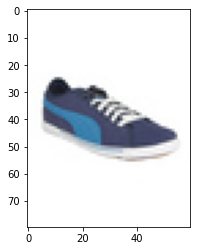

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

images = []

for img in os.listdir('data/myntradataset/images/'):
    if img.endswith('.jpg'):
        id_ = int(img.split('.')[0])
        
        # Check if the image is in the dataframe
        if not df[df['id'] == id_].empty and id_ not in nan_values:
            image = cv2.imread('data/myntradataset/images/' + img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

idx = np.random.randint(0, len(images))
plt.imshow(images[idx])

In [5]:
ids_ = df['id'].values
no_images = []

# Ids without images
for id_ in ids_:
    img = cv2.imread('data/myntradataset/images/' + str(id_) + '.jpg')
    if img is None:
        no_images.append(id_)

no_images

[ WARN:0@20.635] global loadsave.cpp:241 findDecoder imread_('data/myntradataset/images/39403.jpg'): can't open/read file: check file path/integrity
[ WARN:0@21.070] global loadsave.cpp:241 findDecoder imread_('data/myntradataset/images/39410.jpg'): can't open/read file: check file path/integrity
[ WARN:0@21.817] global loadsave.cpp:241 findDecoder imread_('data/myntradataset/images/39401.jpg'): can't open/read file: check file path/integrity
[ WARN:0@22.002] global loadsave.cpp:241 findDecoder imread_('data/myntradataset/images/39425.jpg'): can't open/read file: check file path/integrity
[ WARN:0@22.169] global loadsave.cpp:241 findDecoder imread_('data/myntradataset/images/12347.jpg'): can't open/read file: check file path/integrity


[39403, 39410, 39401, 39425, 12347]

In [6]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def preprocess_text(text):
    return tokenizer(text, return_tensors="pt", padding=True, truncation=True)

In [7]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class FashionDataset(Dataset):
    def __init__(self, csv_file, root_dir, train=True, transform=None):
        self.data = pd.read_csv(csv_file, on_bad_lines='skip')
        self.data = self.data.dropna(subset=['productDisplayName'])
        self.data = self.data[~self.data['id'].isin(no_images)]

        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        train_data, test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        self.data = train_data if self.train else test_data

        self.labels = preprocess_text(self.data['productDisplayName'].astype(str).values.tolist())['input_ids']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 0]) + ".jpg")
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.reshape(3, 224, 224)
        image = torch.tensor(image, dtype=torch.float32)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=True, transform=transform), batch_size=32, shuffle=True)
test_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=False, transform=transform), batch_size=32, shuffle=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1111
Test dataset size: 278


In [9]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.transformer = AutoModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 512)  # BERT outputs 768-dim embeddings

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(output.pooler_output)

In [10]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Freeze the model
        for param in self.model.parameters():
            param.requires_grad = False
            
        self.model.fc = nn.Linear(self.model.fc.in_features, 512)

    def forward(self, x):
        return self.model(x)

In [11]:
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    image_embeddings = nn.functional.normalize(image_embeddings, dim=1)
    text_embeddings = nn.functional.normalize(text_embeddings, dim=1)

    logits = torch.mm(image_embeddings, text_embeddings.t()) / temperature
    labels = torch.arange(len(image_embeddings)).to(image_embeddings.device)
    
    return nn.CrossEntropyLoss()(logits, labels) + nn.CrossEntropyLoss()(logits.t(), labels)

In [12]:
def train(text_encoder, image_encoder, dataloader, optimizer, device, epochs):
    for epoch in range(epochs):
        text_encoder.train()
        image_encoder.train()
        total_loss = 0

        for images, input_ids in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            attention_mask = torch.ones_like(input_ids)
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            optimizer.zero_grad()

            text_embeddings = text_encoder(input_ids, attention_mask)
            image_embeddings = image_encoder(images)

            loss = contrastive_loss(image_embeddings, text_embeddings)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_model = ImageEncoder().to(device)
text_model = TextEncoder().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(image_model.parameters()) + list(text_model.parameters()), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(text_model, image_model, train_dataset, optimizer, device, 1)

/home/maui/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maui/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Save our models
torch.save(image_model.state_dict(), 'image_model.pth')
torch.save(text_model.state_dict(), 'text_model.pth')

In [15]:
from torch.nn.functional import cosine_similarity

def test_clip_model(text_encoder, image_encoder, dataloader, device):
    """
    Evaluate the CLIP model on a test dataset.
    
    Args:
        model (nn.Module): The trained CLIP model.
        test_dataloader (DataLoader): DataLoader for the test dataset.
        device (torch.device): The device to run the evaluation on (CPU or GPU).
    
    Returns:
        float: The average similarity score for matching image-text pairs.
    """
    text_encoder.eval()
    image_encoder.eval()
    total_similarity = 0.0
    count = 0
    
    with torch.no_grad():
        for images, input_ids in dataloader:
            attention_mask = torch.ones_like(input_ids)
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            text_embeddings = text_encoder(input_ids, attention_mask)
            image_embeddings = image_encoder(images)
            
            # Compute cosine similarity
            similarity = cosine_similarity(image_embeddings, text_embeddings, dim=1)
            
            # Accumulate results
            total_similarity += similarity.sum().item()
            count += len(similarity)
    
    # Compute average similarity
    average_similarity = total_similarity / count
    return average_similarity

In [16]:
test_clip_model(text_model, image_model, test_dataset, device)

-0.03581682660484937

In [17]:
def get_embeddings(text_encoder, image_encoder, dataloader, device):
        total_text_embeddings = []
        total_image_embeddings = []
        for images, input_ids in dataloader:
                attention_mask = torch.ones_like(input_ids)
                images = images.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                
                text_embeddings = text_encoder(input_ids, attention_mask)
                image_embeddings = image_encoder(images)

                total_text_embeddings += text_embeddings
                total_image_embeddings += image_embeddings
        return text_embeddings, image_embeddings

In [18]:
text_embeddings, image_embeddings = get_embeddings(text_model, image_model, test_dataset, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 12.53 GiB is allocated by PyTorch, and 53.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
idx = np.random.randint(0, len(text_embeddings))

sim = []
img_idx = []

for i, img_embedding in enumerate(image_embeddings):
    img_idx.append(i)
    similarity = cosine_similarity(img_embedding.unsqueeze(0), text_embeddings[idx].unsqueeze(0), dim=1)
    sim.append(np.abs(similarity.item()))

sim

[0.2792493402957916,
 0.27886611223220825,
 0.2808966636657715,
 0.2803189754486084,
 0.2793749272823334,
 0.279426246881485,
 0.2785947024822235,
 0.27934443950653076,
 0.27933865785598755,
 0.2785298824310303,
 0.2791574001312256,
 0.27887430787086487,
 0.278449147939682,
 0.2785258889198303,
 0.2792377769947052,
 0.27958792448043823,
 0.2796388268470764,
 0.27805638313293457,
 0.28023993968963623]